# TODO
    -Get the correct DRM
    -Generate new fits files


### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [95]:
import os
path = os.getcwd()

if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb #UiB paths
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths

All MAC paths are set!


In [96]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%matplotlib inline

#%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
#pd.set_option('display.float_format', '{:.6E}'.format)
#pd.reset_option("all")

all UiB paths loaded
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# NOTES ON GRB
    -Faint burst with relatively low countrate compared to the other bursts
    -Have all three instruments (ASIM/KW/FERMI)
    -In the LC by KW we see a two structures. The first is around T0 and the other is at T0+2s
        >> We don't have the second structure in the ASIM data

## ASIM
    optimal tlagg = X [s]

Creating df for short GRB
Absolute time correction subtracted from T0
78 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 95 flags
Removed 95 flags from df
df sorted by tus
2020-07-16 22:57:40.634534
first tus:  -197046.44444444444 | max tus:  1812317.0555555555
11787
tus array OK ...


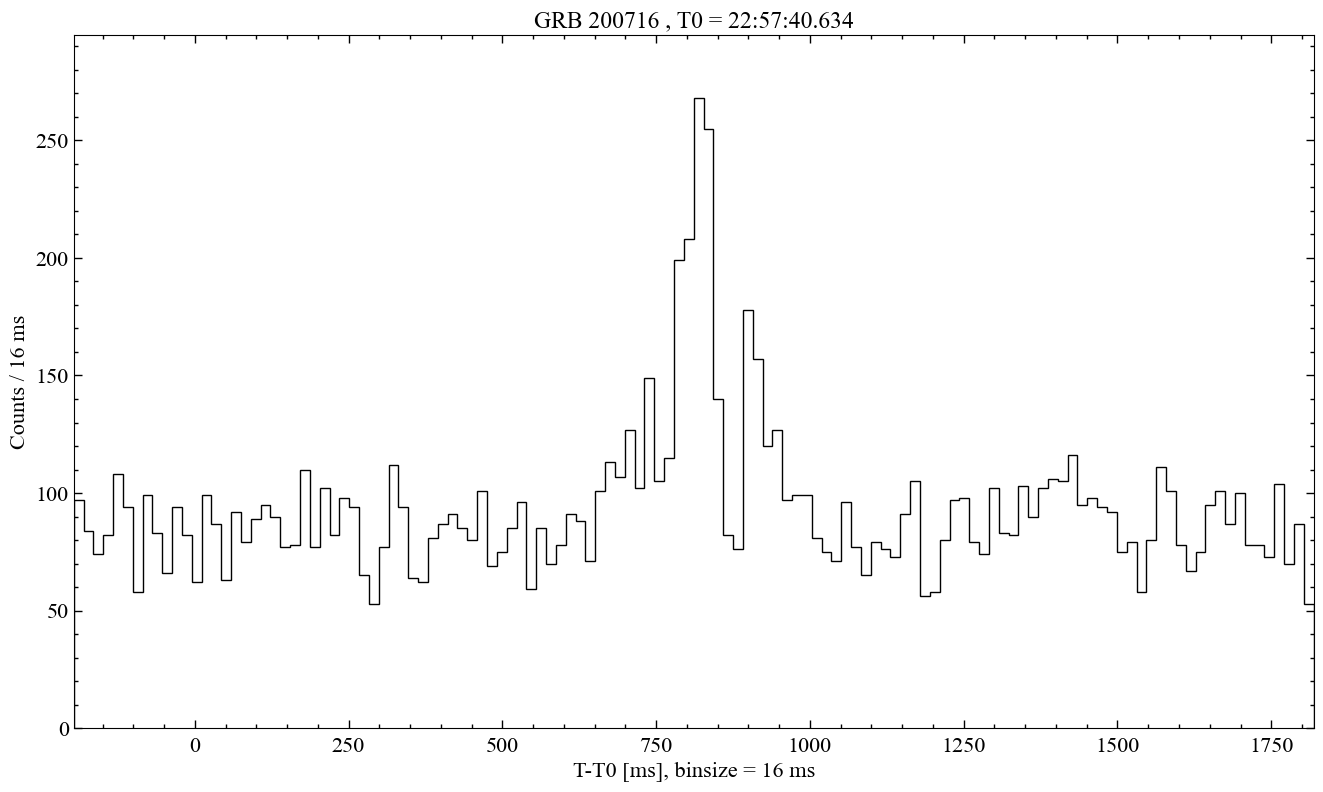

In [97]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB200716",remove_flag=True)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)
print(T0_ASIM)
print("first tus: ",min(tus),"| max tus: ", max(tus))
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=16)

### ASIM tlagg approx

In [99]:
#calculating the tlagg approx based on trigger times and ToF
#bringing into KW ref frame...
#T0_ASIM = 22:57:40.634 abs time correction accounted for
#T0_KW = 22:57:38.337
#ToF = 3.0155
tlagg_approx = np.round(40.634-38.337-3.0155,4)
print(tlagg_approx)

-0.7185


## KW prep

bin start:  -0.512 bin end 1.008


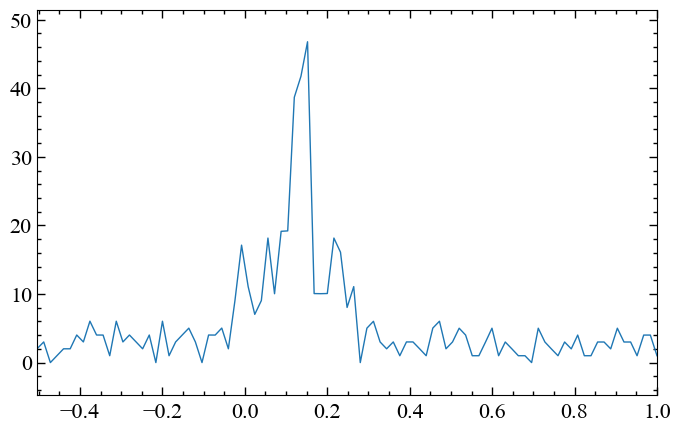

In [162]:
kw_filename = "GRB200716C_16ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.016

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]
print("bin start: ", kw_bin_lo[0], "bin end",kw_bin_lo[i_stop_kw])

kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3
kwLC = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kwLC.plot()

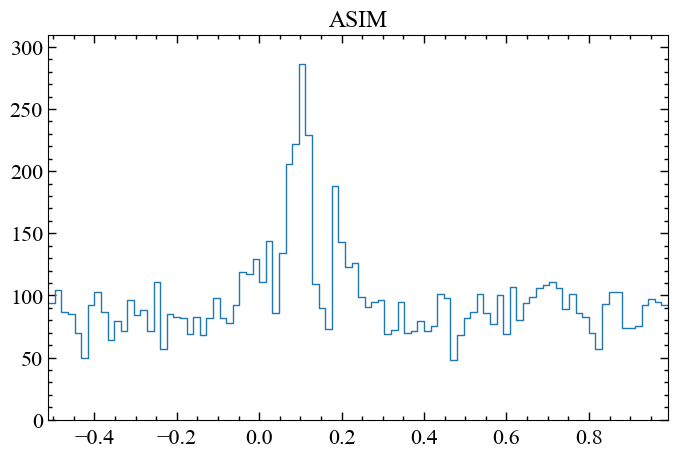

In [163]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds

tus += tlagg_approx
#asim_bins = np.round(np.arange(min(tus),max(tus)+binsize,binsize),3)
kw_bins = np.append(kw_bin_lo,kw_bin_hi[-1])
hist = np.histogram(tus,bins=kw_bins)
asimCounts,asimEdges = hist[0],hist[1]

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM")
plt.ylim(bottom=0)
plt.show()

asimBkg:  83.66666666666667


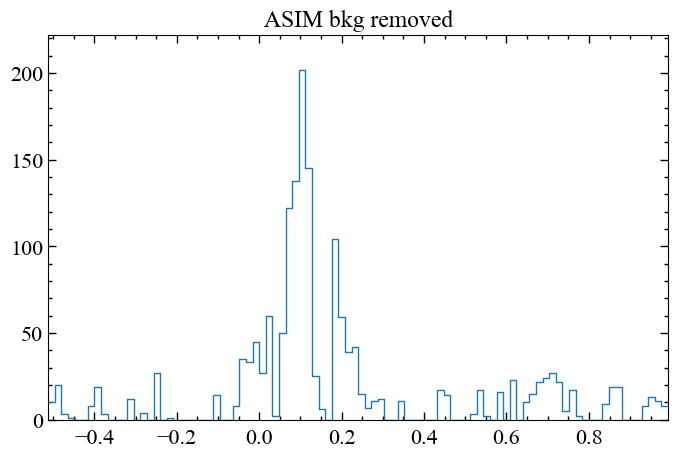

In [164]:
#iAsimBkgStart = find_nearest(asimEdges,min(asimEdges)+0.1)
#iAsimBkgEnd = find_nearest(asimEdges,-0.25)

#asimBkg = sum(asimCounts[iAsimBkgStart:iAsimBkgEnd])/len(asimCounts[iAsimBkgStart:iAsimBkgEnd])
asimBkg = 83.66666666666667 #calculated on the whole ASIM interval for 16ms 
#asimBkg = 10.39929328621908 #calculated on the whole ASIM interval for 2ms
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg
        
plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM bkg removed")
plt.ylim(bottom=0)
plt.show()

## Comparing LC's with approx tshift

In [67]:
#from the LC below, it looks like we can shift the ASIM lc in +-dir by 3 bins (48ms)

In [165]:
#iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
#iAsimEnd = find_nearest(asimEdges,kw_bin_lo[-1])
#asimEdges = asimEdges[iAsimStart:iAsimEnd]
#print(asimEdges)

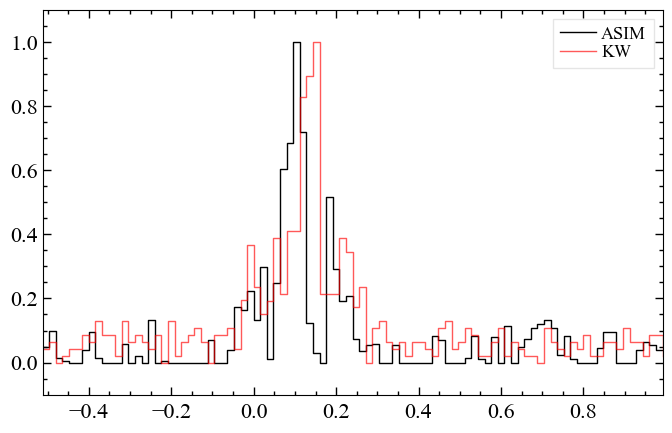

In [166]:
plt.step(x=asimEdges[:-1],y=asimCounts/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)
plt.legend()
plt.show()

### building asimLC
    -Wondering if its correct to add half the binsize? Yes, because it have to match the bin_lo & bin_hi in the KW LC data provided by Anastasia

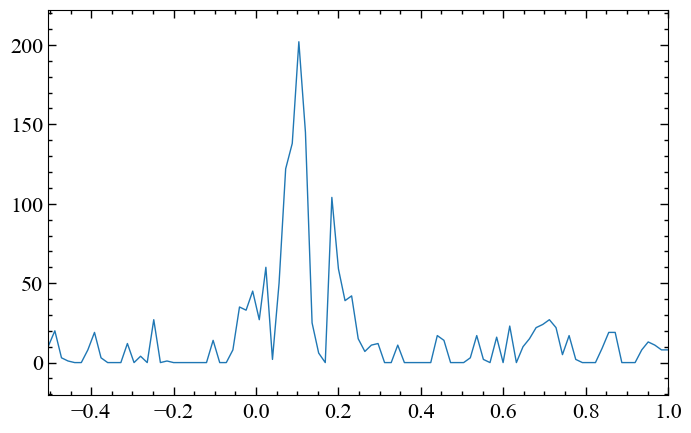

In [167]:
asimLC = LC(time=asimEdges[:-1]+binsize/2,counts=asimCounts,dt=binsize,skip_checks=True)
asimLC.plot()

# CC
    Total tlagg after CC = -0.5366 s. 
    Hard to preform the CC since the data is very noisy and low countrate

Total lagg (s):  -0.6865 | CC lagg:  0.032


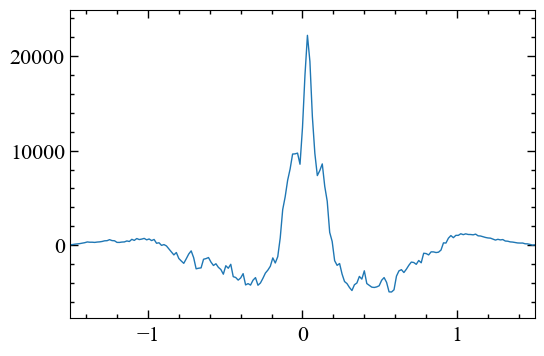

<AxesSubplot:>

In [168]:
CC = CrossCorrelation(kwLC,asimLC,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg)
CC.plot()

In [120]:
#Using kw_bins:
ms16_CC_KW = -0.6865 #s
ms2_CC_KW = -0.6845 #s

#2 ms diff between the two resolutions!
#Having a closer look at the overlapping LC's, and the aligning of the peak looks good! (2ms)

#Very low correlation ~3000

In [24]:
#Using ASIM bins
ms16_CC = -0.6943716577540107 #s
ms2_CC = -0.6854676787463271 #s
# quite the difference: 
print('ms diff: ',abs(ms16_CC-ms2_CC)*1e3)

ms diff:  8.903979007683581


# Building final LC's

In [53]:
tlagg=-0.6854676787463271 #2ms
#tlagg=-0.6943716577540107 #16ms 

In [172]:
ms16_CC_KW,ms2_CC_KW

(-0.6865, -0.6845)

tlagg:  -0.6865
asimBkg:  83.666666


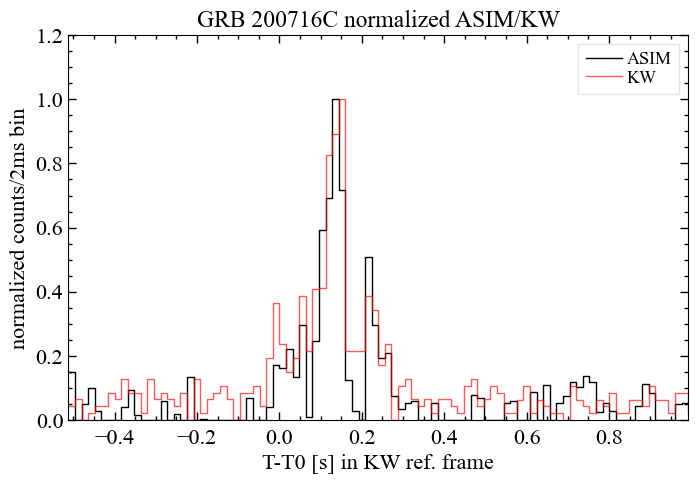

In [174]:
kevArr = ASIM_df["keV"].to_numpy(dtype=np.float32)
tus = ASIM_df["tus"].to_numpy(dtype=np.float64)/1e6 #converting to seconds
print('tlagg: ',tlagg)
tus += ms16_CC_KW #tlagg 

hist = np.histogram(tus,bins=kw_bins)
asimCounts,asimEdges = hist[0],hist[1]

asimBkg = 83.666666 #10.39929328621908
print("asimBkg: ",asimBkg)
for i,count in enumerate(asimCounts):
    if count-asimBkg <= 0:
        asimCounts[i] = 0
    else:
        asimCounts[i] -= asimBkg

#iAsimStart = find_nearest(asimEdges,kw_bin_lo[0])
#iAsimEnd = find_nearest(asimEdges,kw_bin_hi[-1])

plt.step(x=asimEdges[:-1],y=asimCounts/max(asimCounts),where="post",label="ASIM",color="black")
plt.step(x=kw_bin_lo,y=kwCounts/max(kwCounts),where="post",label="KW",color="red",alpha=0.65)

plt.title("GRB 200716C normalized ASIM/KW")
plt.xlabel("T-T0 [s] in KW ref. frame")
plt.ylabel("normalized counts/2ms bin")
#plt.vlines(x=0.0,ymin=0,ymax=1.1,color="g",label="T0: {}".format(T0_KW.isoformat(timespec="milliseconds")),alpha=0.6,linestyle="--")
plt.legend()
#plt.xlim(left=0.0,right=0.20)
plt.ylim(bottom=0,top=1.2)
plt.show()

In [177]:
#Ok CC for 2ms. Hard to see how well it's aligned, but the general structure seems to be aligned (main and second). Main peak are overlapping exactly 
#Checking 16ms: The top is well aligned. ASIM peak comes one bin before KW, but the other structures are very similar.
#    >>Using the tlagg from 2ms CC: Structure is more similar using the 2ms calibration!

# CC looked good on 16ms resolution for 2ms CC tlagg!

In [176]:
#Optimal tlagg:  -0.6865 --> Calibrated using 2ms bins. Works very well for 2ms and 16ms

# Extracting ASIM data

In [178]:
tlagg=np.round(-0.6865,4)
print(tlagg)

-0.6865


In [179]:
ASIM_df,T0 = complete_df(grb_id="GRB200716",remove_flag=True)
T0_shift = T0 + timedelta(seconds=tlagg)
ASIM_df["tus"] = ASIM_df["tus"].to_numpy()+tlagg*1e6

Creating df for short GRB
Absolute time correction subtracted from T0
78 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 95 flags
Removed 95 flags from df
df sorted by tus


tus array OK ...


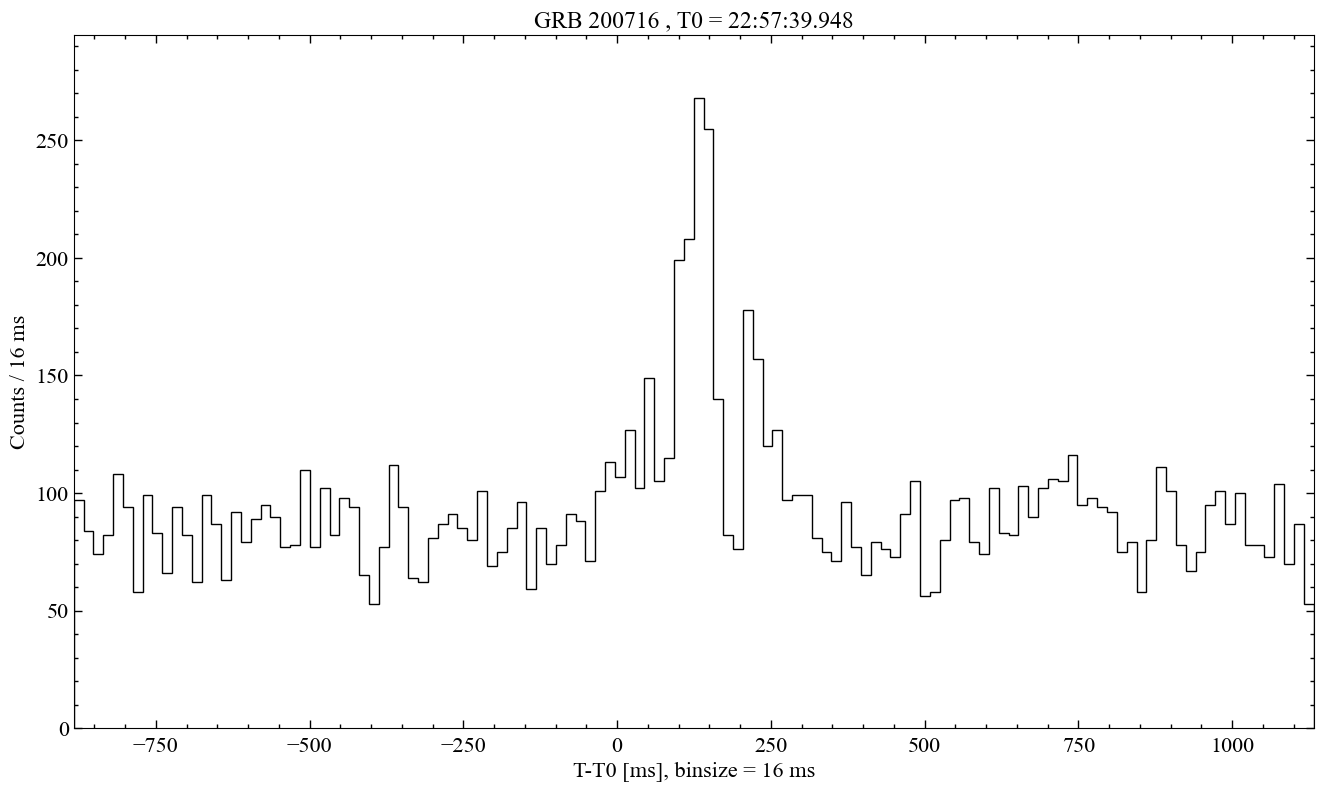

In [183]:
plot_HED(tus_arr=ASIM_df["tus"].to_numpy(),T0=T0_shift,binsize=16)
#maybe add a highlight key to show where the extracted interval is

In [46]:
keV_df,tus_check = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                  keV_interval="max",
                  check_LC = True)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  1109
n triggers are within bounds  1109
keV bins are set for HED
Energies binned!


tus array OK ...


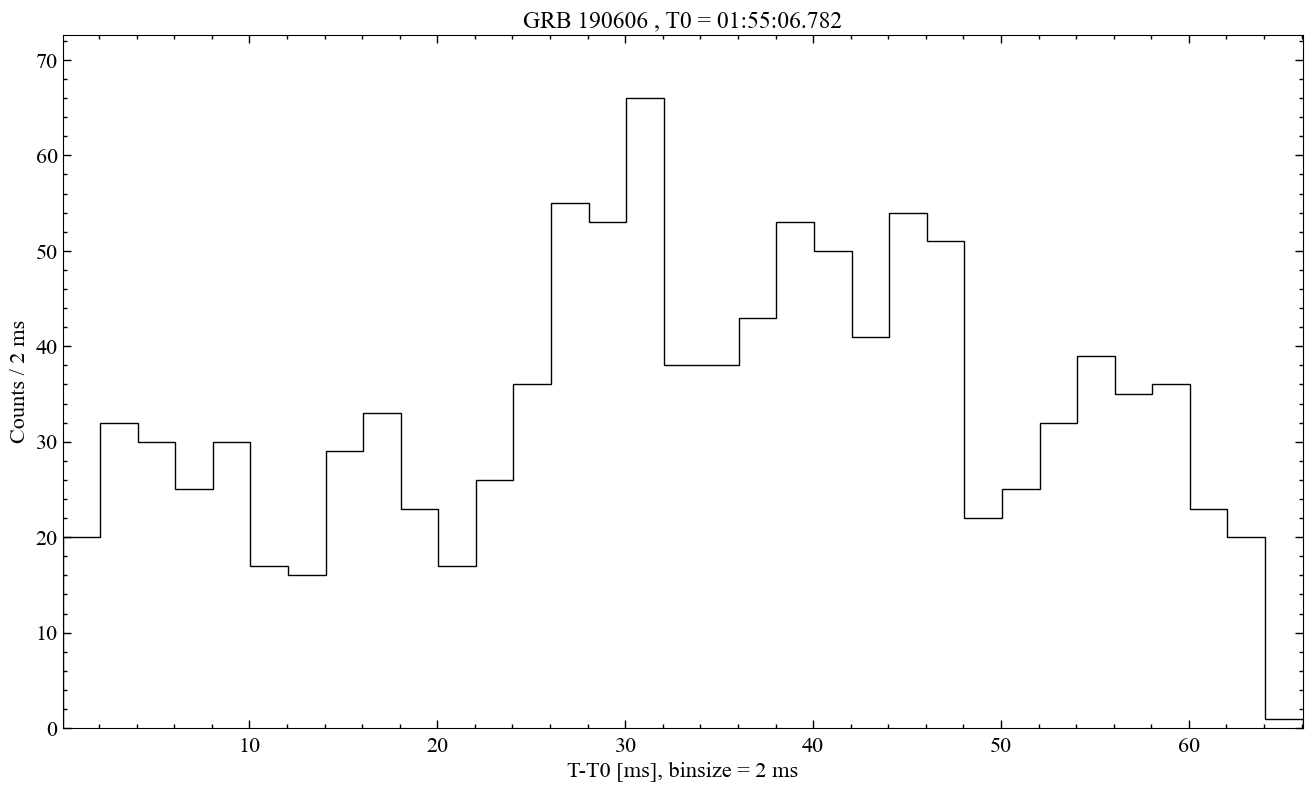

In [47]:
plot_HED(tus_arr=tus_check*1e6,T0=T0_shift,binsize=2)

### bakground extraction 

In [117]:
keV_bg,bg_LC = keV_hist(df=ASIM_df,time_interval=(-0.9,-0.1),
                 keV_interval="max",
                 check_LC=True)

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  8662
n triggers are within bounds  8662
keV bins are set for HED
Energies binned!


tus array OK ...


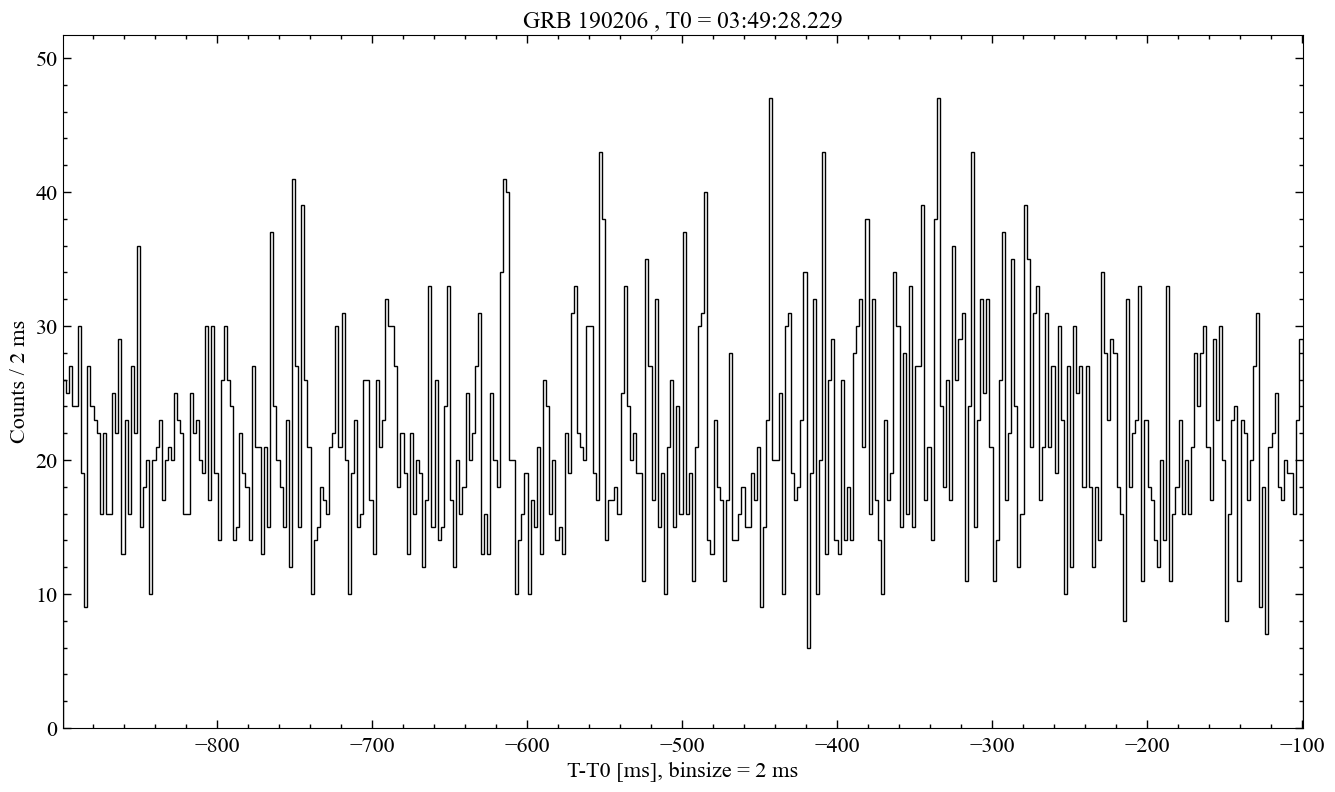

In [118]:
plot_HED(tus_arr=bg_LC*1e6,binsize=2,T0=T0_shift)

# Exporting fits files

In [119]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb

### PHA

In [184]:
T0_shift.isoformat()

'2020-07-16T22:57:39.948034'

In [122]:
pha_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-07-16T22:57:39.948','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.0,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [?,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [?,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB200716C','Name of the observed object'], #<str> 
    'RA_OBJ': [196.013,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [29.633,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB200716.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB200716.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB200716.pha','PHA filename'] #<str>  ('example.pha')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's


In [123]:
bin_lo = keV_df['bins_keV'].to_numpy()[:-1]
bin_hi = keV_df['bins_keV'].to_numpy()[1:]
counts = keV_df['counts'].to_numpy()[1:]
err = keV_df['poisson_error_counts'].to_numpy()[1:]

In [124]:
len(bin_lo),len(bin_hi),len(counts),len(err)

(40, 40, 40, 40)

In [125]:
generatePHA(PHA_dict=pha_dict,bin_lo=bin_lo,bin_hi=bin_hi,stat_err=err,counts=counts)

### BAK

In [185]:
bak_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2020-07-16T22:57:39.948','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [?,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [?,'End time of background spectrum accumulation'], #<float> [s]
'EXPOSURE': [?,'[s] Integration time in seconds for the BAK data'], #<float> 
'OBJECT': ['GRB200716','Name of the observed object'], #<str> 
'RA_OBJ': [196.013,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [29.633,'[deg] Dec of source'], #<float>
'FILENAME': ['HED_GRB200716.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
#More keys can be declated. Set generatePHA(see_template=True) to view avalible keys,values & comments from the template HDR's

SyntaxError: invalid syntax (3330527777.py, line 4)

In [127]:
bak_counts = keV_bg['counts'].to_numpy()[1:]
bak_err = keV_bg['poisson_error_counts'].to_numpy()[1:]

In [128]:
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=bak_counts,stat_err=bak_err)

### RSP

In [132]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2020-07-16T22:57:39.948','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [?,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [?,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [?,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB200716C','Name of the observed object'], #<str> 
    'RA_OBJ': [196.013,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [29.633,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB200716.rsp','RSP filename'] #<str>  ('example.pha')
}

In [187]:
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

In [188]:
theta,phi = 143.834,-140.018 #theta, phi angles for the incomming radiation reaching the ISS
drm_path = '/Users/andreas/phys/master/HED_DRM/'
drmfname = find_DRM_file(dir_path=drm_path,theta=theta,phi=phi)
print(drmfname)

HED_drm_mats_150.00_-135.00.txt


In [134]:
generateRSP(RSP_dict=rsp_dict,DRM_fname=drmfname,bin_lo=bin_lo,bin_hi=bin_hi,theta=110.882,phi=-36.976)

# Fitting
    